# 項目: 企業的避稅行為預測

欄位說明:

- Global Company Key: 全球公司識別碼
- Data Date: 資料日期
- Data Year - Fiscal: 財務年度
- Industry Format: 產業格式
- Level of Consolidation - Company Annual Descriptor: 公司年度合併層級描述
- Population Source: 數據來源
- Data Format: 資料格式
- Ticker Symbol: 股票代碼
- CUSIP: CUSIP 識別碼（美國證券識別碼）
- Company Name: 公司名稱
- ISO Currency Code: ISO 貨幣代碼
- Assets - Total: 總資產
- Capital Expenditures: 資本支出
- Common Shares Outstanding: 已發行普通股數量
- Operating Activities - Net Cash Flow: 營運活動現金流量（淨額）
- Pretax Income: 稅前收益
- Special Items: 特殊項目
- Income Taxes Paid: 已支付所得稅
- Income Taxes - Total: 所得稅總額
- Active/Inactive Status Marker: 活躍/非活躍狀態標記
- year: 資料標記

避稅行為衡量標準：

- Book-Tax Difference (BTD) = 稅前收入 - 總所得稅
  - BTD 越高，代表企業可能有避稅行為。

## 引入函式庫

In [1156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

## 資料讀取

In [1157]:
original_data = pd.read_csv('/Users/twcch/Documents/Drive/8. 數據/Compustat.csv')
original_data

,Global Company Key,Data Date,Data Year - Fiscal,Industry Format,Level of Consolidation - Company Annual Descriptor,Population Source,Data Format,Ticker Symbol,CUSIP,Company Name,...,Assets - Total,Capital Expenditures,Common Shares Outstanding,Operating Activities - Net Cash Flow,Pretax Income,Special Items,Income Taxes Paid,Income Taxes - Total,Active/Inactive Status Marker,year
0,1004,1999/05/31,1998,INDL,C,D,STD,AIR,361105,AAR CORP,...,726.630,36.131,27.381,28.525,59.786,0.000,4.400,18.115,A,1998
1,1010,1998/12/31,1998,INDL,C,D,STD,4165A,00099V004,ACF INDUSTRIES HOLDING CORP,...,3257.300,101.700,0.015,92.400,108.800,0.000,24.500,41.400,I,1998
2,1013,1998/10/31,1998,INDL,C,D,STD,ADCT,886309,ADC TELECOMMUNICATIONS INC,...,1300.587,94.549,134.897,82.078,225.734,0.000,75.275,79.007,I,1998
3,1019,1998/12/31,1998,INDL,C,D,STD,AFAP,1038108,AFA PROTECTIVE SYSTEMS INC,...,29.283,2.144,0.172,5.699,3.175,0.000,1.150,1.528,I,1998
4,1021,1998/06/30,1998,INDL,C,D,STD,IWKS,1058205,AFP IMAGING CORP,...,18.661,0.480,9.768,-0.658,-3.264,-3.321,0.162,0.064,I,1998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206528,318005,2016/12/31,2016,INDL,C,D,STD,ARGX,04016X101,ARGEN-X SE,...,111.611,0.886,20.126,11.184,-22.554,0.000,NaN,0.000,A,2016
206529,318728,2016/12/31,2016,FS,C,D,STD,ATH,G0684D107,ATHENE HOLDING LTD,...,86720.000,NaN,NaN,NaN,753.000,-22.000,NaN,-52.000,A,2016
206530,318728,2016/12/31,2016,INDL,C,D,STD,ATH,G0684D107,ATHENE HOLDING LTD,...,86720.000,0.000,200.411,1199.000,753.000,-22.000,-31.000,-52.000,A,2016
206531,318815,2016/12/31,2016,INDL,C,D,STD,MTP,59564R104,MIDATECH PHARMA PLC,...,69.937,1.662,24.350,-16.144,-36.175,-14.080,-2.036,-11.301,A,2016


In [1158]:
cleaned_data = original_data.copy()

## 資料前處理

### 資料分析(處理前)

#### 缺失值分析

In [1159]:
print("\n[各欄位缺失值統計]")
missing_count = cleaned_data.isnull().sum()
missing_ratio = (missing_count / len(cleaned_data)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_count,
    'Missing Ratio (%)': missing_ratio
}).sort_values(by='Missing Values', ascending=False)
display(missing_df)


[各欄位缺失值統計]


,Missing Values,Missing Ratio (%)
Income Taxes Paid,86739,41.997647
Capital Expenditures,59507,28.812345
Operating Activities - Net Cash Flow,58556,28.351886
Common Shares Outstanding,32353,15.664809
Special Items,31725,15.360741
Income Taxes - Total,30119,14.583142
Pretax Income,30112,14.579752
Assets - Total,29362,14.216614
CUSIP,717,0.347160
Ticker Symbol,110,0.053260


預執行策略:

- `CUSIP`, `Ticker Symbol`為空值，表示對應不到美國證券識別碼與股票代碼，但是有主要的`Global Company Key`可以辨識，所以忽略不處理
- 因為缺失值的比例過高，因原因不可考，不宜直接刪除，傾向採用以下兩種資料合成方式處理，先採用`多重插補`處理
  - 多重插補(Multiple Imputation by Chained Equations; MICE): 針對每個欄位建立迴歸模型去預測缺失值
  - K-近鄰插補(KNNImputer): 尋找相似的樣本(近鄰)來決定該筆缺失值的合理填補

#### 描述性統計

In [1160]:
print("\n[欄位統計描述]")
cols = ['Assets - Total', 'Capital Expenditures', 'Common Shares Outstanding', 'Operating Activities - Net Cash Flow', 'Pretax Income', 'Special Items', 'Income Taxes Paid', 'Income Taxes - Total']
display(cleaned_data[cols].describe())


[欄位統計描述]


,Assets - Total,Capital Expenditures,Common Shares Outstanding,Operating Activities - Net Cash Flow,Pretax Income,Special Items,Income Taxes Paid,Income Taxes - Total
count,1.771710e+05,147026.000000,174180.000000,147977.000000,176421.000000,174808.000000,119794.000000,176414.000000
mean,1.311150e+04,208.595842,122.301076,375.283055,253.674005,-28.987341,76.929469,79.599613
std,1.092956e+05,1236.675484,833.305389,2746.563123,1837.849080,592.774985,663.908013,613.690316
min,0.000000e+00,-401.609000,0.000000,-140537.000000,-108761.000000,-51066.200000,-6318.000000,-45415.000000
25%,5.105900e+01,0.333000,7.413750,-0.728000,-3.433000,-2.303000,0.004000,0.000000
50%,3.953380e+02,4.477000,22.104000,9.729000,5.143000,0.000000,1.419000,0.998000
75%,2.044782e+03,44.111000,61.325750,107.336000,65.630000,0.000000,16.639250,16.706000
max,3.771200e+06,50233.741000,100092.395000,166671.531000,103051.000000,120517.000000,142226.866000,37162.000000


預執行策略:

- `Capital Expenditures`, `Income Taxes Paid`, `Income Taxes - Total`: 最小值有負值，這是不合理的，預計刪除<0的資料
- 當以下狀況發生，可能代表資料分佈可能是偏態，可能會採取刪除該筆資料的策略，而非直接套用MinMaxScaler或Z-Score標準化，因為當有嚴重的離群值時，可能會對整體分佈是否帶來更大的扭曲或失真，待後續近一步評估
  - 若平均值與中位數相差過大，代表分佈有可能是偏態，被極端值拉高(或拉低)
  - 最小值或最大值跟整體分布差距過大，可能代表存在離群值。
- 當以下狀況發生，採用re-scaling, Standardization處理
  - 標準差可以看出該指標在樣本中變化有多大。若某些財務指標標準差特別高，代表企業間在該指標上的差異巨大，例如某些公司資產或營收極高，而多數公司則維持在較小規模。

#### 進階分析描述統計的結果

##### Assets - Total欄位分析

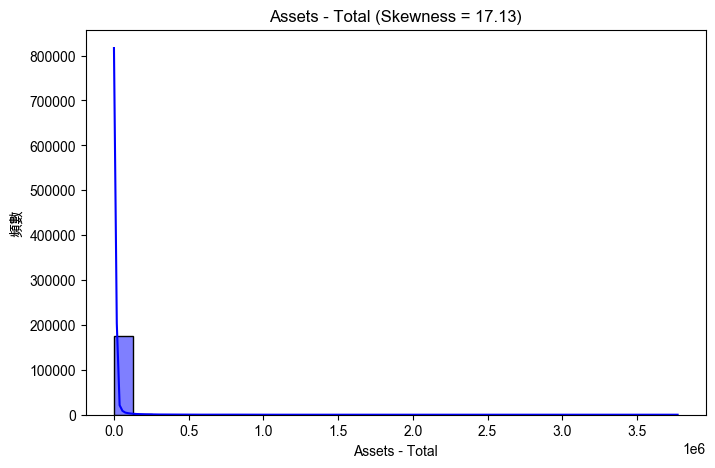

In [1161]:
column_name = 'Assets - Total'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

In [1162]:
column_name = 'Assets - Total'
bins = 10  # 設定級距數量

# 先移除 NaN 值
filtered_data = cleaned_data[column_name].dropna()

# 確保至少有數據
if not filtered_data.empty:
    counts, bin_edges = np.histogram(filtered_data, bins=bins)
    
    # 建立 DataFrame 來顯示結果
    bin_df = pd.DataFrame({
        '級距範圍': [f"{bin_edges[i]:.2f} ~ {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)],
        '資料筆數': counts
    })

    print(bin_df)
else:
    print("無有效數據可用，請確認資料內容。")

                      級距範圍    資料筆數
0         0.00 ~ 377119.99  175957
1    377119.99 ~ 754239.97     536
2   754239.97 ~ 1131359.96     266
3  1131359.96 ~ 1508479.94     104
4  1508479.94 ~ 1885599.93     118
5  1885599.93 ~ 2262719.91      84
6  2262719.91 ~ 2639839.90      64
7  2639839.90 ~ 3016959.88      22
8  3016959.88 ~ 3394079.87      16
9  3394079.87 ~ 3771199.85       4


預執行策略:

從圖表可以看出"少量極端高值 + 大量集中在相對較低範圍"，代表資料有嚴重偏態，若直接套用MinMaxScaler或Z-Score標準化，通常會出現以下問題：

- 少數高值對最大值或平均值造成嚴重拉扯
- 大多數資料被壓縮在相當小的範圍，後續模型難以分辨細微差異

處理嚴重偏態分佈常見方法如下，先採用`Robust Scaler(使用中位數 (Median) 和四分位距 (IQR) 進行縮放，對極端值較不敏感。)`處理：

- Yeo-Johnson 轉換
- 對數轉換 (Log Transform)
- Winsorizing (截尾/壓縮極端值)
- Robust Scaler / Robust Standardization
- 分群處理 (Grouping 或 Clustering 後再縮放)

##### Capital Expenditures欄位分析

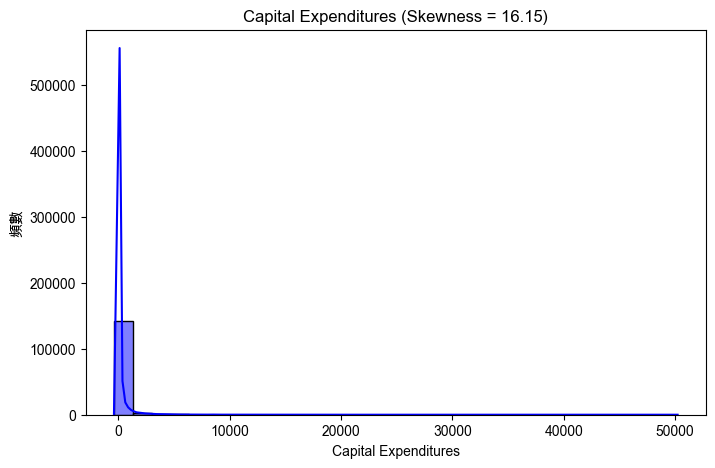

In [1163]:
column_name = 'Capital Expenditures'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

In [1164]:
column_name = 'Capital Expenditures'
bins = 10  # 設定級距數量

# 先移除 NaN 值
filtered_data = cleaned_data[column_name].dropna()

# 確保至少有數據
if not filtered_data.empty:
    counts, bin_edges = np.histogram(filtered_data, bins=bins)
    
    # 建立 DataFrame 來顯示結果
    bin_df = pd.DataFrame({
        '級距範圍': [f"{bin_edges[i]:.2f} ~ {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)],
        '資料筆數': counts
    })

    print(bin_df)
else:
    print("無有效數據可用，請確認資料內容。")

                  級距範圍    資料筆數
0    -401.61 ~ 4661.93  145834
1    4661.93 ~ 9725.46     698
2   9725.46 ~ 14789.00     257
3  14789.00 ~ 19852.53     119
4  19852.53 ~ 24916.07      49
5  24916.07 ~ 29979.60      31
6  29979.60 ~ 35043.14      18
7  35043.14 ~ 40106.67       7
8  40106.67 ~ 45170.21       9
9  45170.21 ~ 50233.74       4


預執行策略:

同上

##### Common Shares Outstanding欄位分析

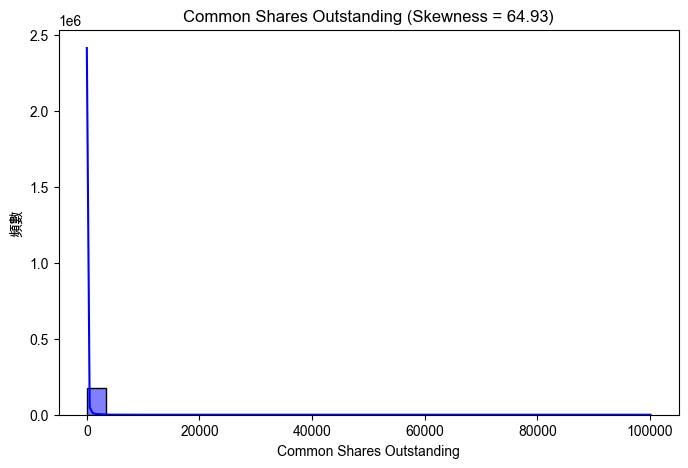

In [1165]:
column_name = 'Common Shares Outstanding'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

In [1166]:
column_name = 'Common Shares Outstanding'
bins = 10  # 設定級距數量

# 先移除 NaN 值
filtered_data = cleaned_data[column_name].dropna()

# 確保至少有數據
if not filtered_data.empty:
    counts, bin_edges = np.histogram(filtered_data, bins=bins)
    
    # 建立 DataFrame 來顯示結果
    bin_df = pd.DataFrame({
        '級距範圍': [f"{bin_edges[i]:.2f} ~ {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)],
        '資料筆數': counts
    })

    print(bin_df)
else:
    print("無有效數據可用，請確認資料內容。")

                   級距範圍    資料筆數
0       0.00 ~ 10009.24  174072
1   10009.24 ~ 20018.48      88
2   20018.48 ~ 30027.72       7
3   30027.72 ~ 40036.96       3
4   40036.96 ~ 50046.20       0
5   50046.20 ~ 60055.44       3
6   60055.44 ~ 70064.68       0
7   70064.68 ~ 80073.92       0
8   80073.92 ~ 90083.16       0
9  90083.16 ~ 100092.40       7


預執行策略:

同上

##### Operating Activities - Net Cash Flow欄位分析

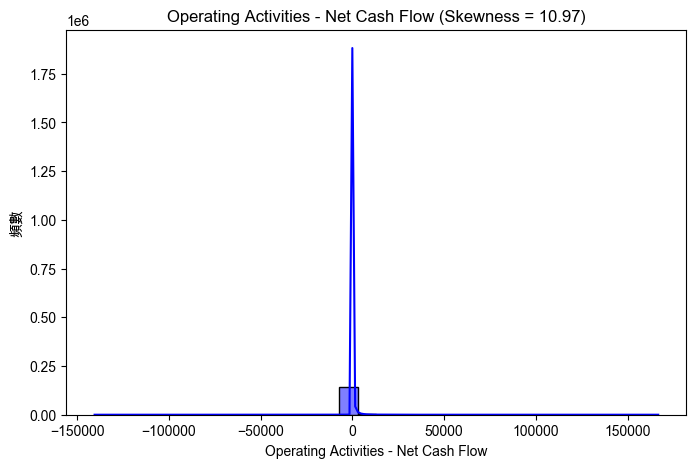

In [1167]:
column_name = 'Operating Activities - Net Cash Flow'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

In [1168]:
column_name = 'Operating Activities - Net Cash Flow'
bins = 10  # 設定級距數量

# 先移除 NaN 值
filtered_data = cleaned_data[column_name].dropna()

# 確保至少有數據
if not filtered_data.empty:
    counts, bin_edges = np.histogram(filtered_data, bins=bins)
    
    # 建立 DataFrame 來顯示結果
    bin_df = pd.DataFrame({
        '級距範圍': [f"{bin_edges[i]:.2f} ~ {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)],
        '資料筆數': counts
    })

    print(bin_df)
else:
    print("無有效數據可用，請確認資料內容。")

                      級距範圍    資料筆數
0  -140537.00 ~ -109816.15       3
1   -109816.15 ~ -79095.29       1
2    -79095.29 ~ -48374.44      14
3    -48374.44 ~ -17653.59      64
4     -17653.59 ~ 13067.27  147054
5      13067.27 ~ 43788.12     754
6      43788.12 ~ 74508.97      68
7     74508.97 ~ 105229.82      13
8    105229.82 ~ 135950.68       4
9    135950.68 ~ 166671.53       2


預執行策略:

同上

##### Pretax Income欄位分析

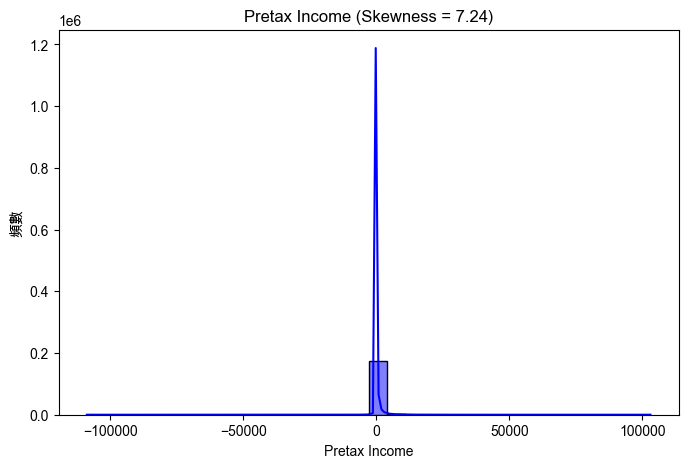

In [1169]:
column_name = 'Pretax Income'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

In [1170]:
column_name = 'Pretax Income'
bins = 10  # 設定級距數量

# 先移除 NaN 值
filtered_data = cleaned_data[column_name].dropna()

# 確保至少有數據
if not filtered_data.empty:
    counts, bin_edges = np.histogram(filtered_data, bins=bins)
    
    # 建立 DataFrame 來顯示結果
    bin_df = pd.DataFrame({
        '級距範圍': [f"{bin_edges[i]:.2f} ~ {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)],
        '資料筆數': counts
    })

    print(bin_df)
else:
    print("無有效數據可用，請確認資料內容。")

                     級距範圍    資料筆數
0  -108761.00 ~ -87579.80       2
1   -87579.80 ~ -66398.60       2
2   -66398.60 ~ -45217.40       5
3   -45217.40 ~ -24036.20      16
4    -24036.20 ~ -2855.00     420
5     -2855.00 ~ 18326.20  175652
6     18326.20 ~ 39507.40     294
7     39507.40 ~ 60688.60      22
8     60688.60 ~ 81869.80       6
9    81869.80 ~ 103051.00       2


預執行策略:

同上

##### Special Items欄位分析

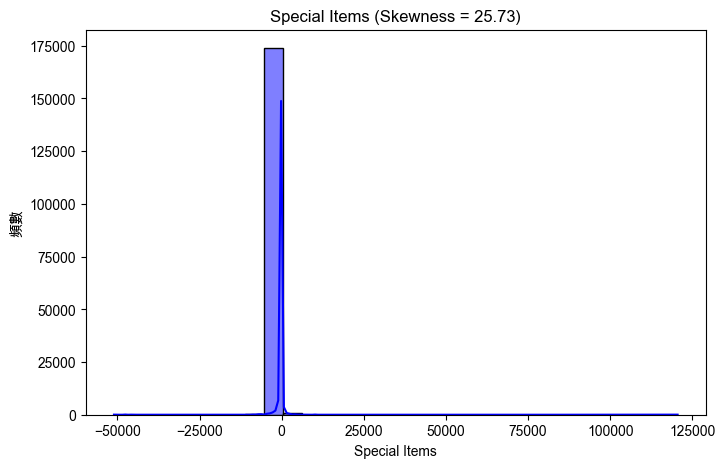

In [1171]:
column_name = 'Special Items'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

In [1172]:
column_name = 'Special Items'
bins = 10  # 設定級距數量

# 先移除 NaN 值
filtered_data = cleaned_data[column_name].dropna()

# 確保至少有數據
if not filtered_data.empty:
    counts, bin_edges = np.histogram(filtered_data, bins=bins)
    
    # 建立 DataFrame 來顯示結果
    bin_df = pd.DataFrame({
        '級距範圍': [f"{bin_edges[i]:.2f} ~ {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)],
        '資料筆數': counts
    })

    print(bin_df)
else:
    print("無有效數據可用，請確認資料內容。")

                    級距範圍    資料筆數
0  -51066.20 ~ -33907.88       6
1  -33907.88 ~ -16749.56      16
2     -16749.56 ~ 408.76  174040
3      408.76 ~ 17567.08     738
4    17567.08 ~ 34725.40       7
5    34725.40 ~ 51883.72       0
6    51883.72 ~ 69042.04       0
7    69042.04 ~ 86200.36       0
8   86200.36 ~ 103358.68       0
9  103358.68 ~ 120517.00       1


預執行策略:

同上

##### Income Taxes Paid欄位分析

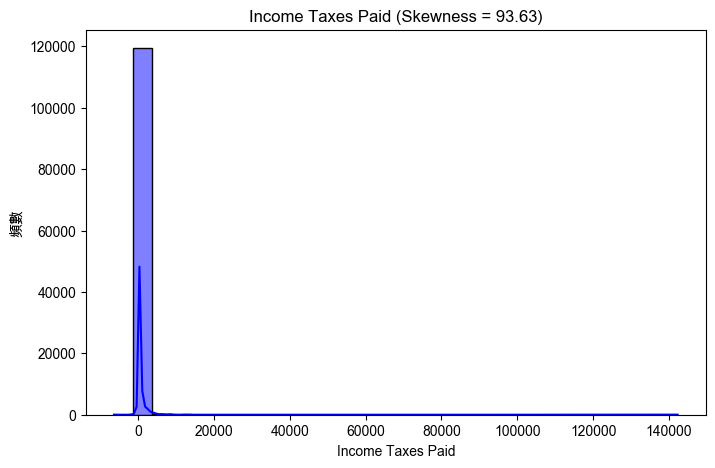

In [1173]:
column_name = 'Income Taxes Paid'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

In [1174]:
column_name = 'Income Taxes Paid'
bins = 10  # 設定級距數量

# 先移除 NaN 值
filtered_data = cleaned_data[column_name].dropna()

# 確保至少有數據
if not filtered_data.empty:
    counts, bin_edges = np.histogram(filtered_data, bins=bins)
    
    # 建立 DataFrame 來顯示結果
    bin_df = pd.DataFrame({
        '級距範圍': [f"{bin_edges[i]:.2f} ~ {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)],
        '資料筆數': counts
    })

    print(bin_df)
else:
    print("無有效數據可用，請確認資料內容。")

                    級距範圍    資料筆數
0     -6318.00 ~ 8536.49  119720
1     8536.49 ~ 23390.97      65
2    23390.97 ~ 38245.46       8
3    38245.46 ~ 53099.95       0
4    53099.95 ~ 67954.43       0
5    67954.43 ~ 82808.92       0
6    82808.92 ~ 97663.41       0
7   97663.41 ~ 112517.89       0
8  112517.89 ~ 127372.38       0
9  127372.38 ~ 142226.87       1


預執行策略:

同上

##### Income Taxes - Total欄位分析

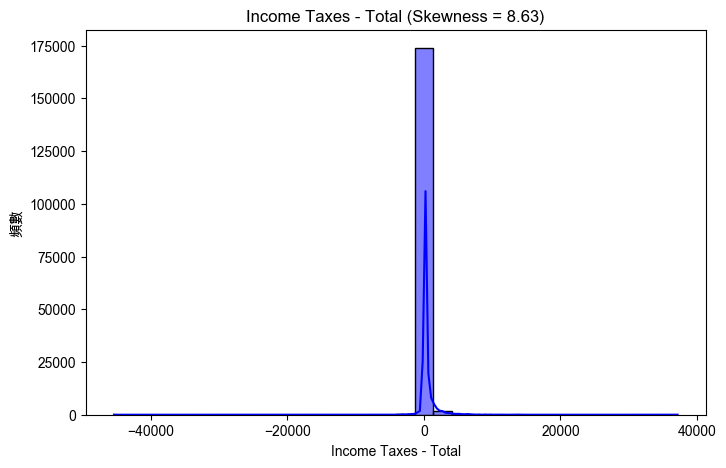

In [1175]:
column_name = 'Income Taxes - Total'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

In [1176]:
column_name = 'Income Taxes Paid'
bins = 10  # 設定級距數量

# 先移除 NaN 值
filtered_data = cleaned_data[column_name].dropna()

# 確保至少有數據
if not filtered_data.empty:
    counts, bin_edges = np.histogram(filtered_data, bins=bins)
    
    # 建立 DataFrame 來顯示結果
    bin_df = pd.DataFrame({
        '級距範圍': [f"{bin_edges[i]:.2f} ~ {bin_edges[i+1]:.2f}" for i in range(len(bin_edges)-1)],
        '資料筆數': counts
    })

    print(bin_df)
else:
    print("無有效數據可用，請確認資料內容。")

                    級距範圍    資料筆數
0     -6318.00 ~ 8536.49  119720
1     8536.49 ~ 23390.97      65
2    23390.97 ~ 38245.46       8
3    38245.46 ~ 53099.95       0
4    53099.95 ~ 67954.43       0
5    67954.43 ~ 82808.92       0
6    82808.92 ~ 97663.41       0
7   97663.41 ~ 112517.89       0
8  112517.89 ~ 127372.38       0
9  127372.38 ~ 142226.87       1


預執行策略:

同上

### 資料分析(處理後)

#### 補缺失值(多重差補)

補缺失值

In [1177]:
na_cols = ['Income Taxes Paid', 'Capital Expenditures', 'Operating Activities - Net Cash Flow', 'Common Shares Outstanding', 'Special Items', 'Income Taxes - Total', 'Pretax Income', 'Assets - Total']

# 取出數值型 DataFrame
df_num = cleaned_data[na_cols].copy()

# 使用 IterativeImputer 進行插補
imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42
)
imputed_array = imputer.fit_transform(df_num)
df_imputed = pd.DataFrame(imputed_array, columns=df_num.columns)

# 將補好的欄位放回原 DataFrame
for c in na_cols:
    cleaned_data[c] = df_imputed[c]


In [1178]:
print("\n[各欄位缺失值統計]")
missing_count = cleaned_data.isnull().sum()
missing_ratio = (missing_count / len(cleaned_data)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_count,
    'Missing Ratio (%)': missing_ratio
}).sort_values(by='Missing Values', ascending=False)
display(missing_df)


[各欄位缺失值統計]


,Missing Values,Missing Ratio (%)
CUSIP,717,0.34716
Ticker Symbol,110,0.05326
Global Company Key,0,0.00000
Capital Expenditures,0,0.00000
Active/Inactive Status Marker,0,0.00000
Income Taxes - Total,0,0.00000
Income Taxes Paid,0,0.00000
Special Items,0,0.00000
Pretax Income,0,0.00000
Operating Activities - Net Cash Flow,0,0.00000


#### 刪除異常值

`Capital Expenditures`, `Income Taxes Paid`, `Income Taxes - Total`: 最小值有負值，這是不合理的，刪除<0的資料

In [1179]:
cleaned_data = cleaned_data[cleaned_data['Capital Expenditures'] > 0]
cleaned_data = cleaned_data[cleaned_data['Income Taxes Paid'] > 0]
cleaned_data = cleaned_data[cleaned_data['Income Taxes - Total'] > 0]

In [1180]:
print("\n[欄位統計描述]")
cols = ['Assets - Total', 'Capital Expenditures', 'Common Shares Outstanding', 'Operating Activities - Net Cash Flow', 'Pretax Income', 'Special Items', 'Income Taxes Paid', 'Income Taxes - Total']
display(cleaned_data[cols].describe())


[欄位統計描述]


,Assets - Total,Capital Expenditures,Common Shares Outstanding,Operating Activities - Net Cash Flow,Pretax Income,Special Items,Income Taxes Paid,Income Taxes - Total
count,1.303550e+05,130355.000000,130355.000000,130355.000000,130355.000000,130355.000000,130355.000000,130355.000000
mean,1.576340e+04,286.562800,150.522543,546.546350,403.347165,-26.432263,115.155552,128.935459
std,1.096170e+05,1288.110686,838.406758,2662.242955,1866.607370,397.446169,686.311060,631.461154
min,0.000000e+00,0.001000,-704.637332,-75741.432000,-44156.000000,-45873.000000,0.001000,0.001000
25%,3.297930e+02,10.184000,9.150000,24.500500,7.920500,-19.959507,3.245000,2.821000
50%,1.717409e+03,85.878371,35.808000,125.143371,78.576000,-0.500000,19.800000,25.427000
75%,7.211822e+03,173.201074,91.004623,304.520364,204.295000,0.000000,59.267701,65.523343
max,3.771200e+06,50233.741000,91345.817000,166671.531000,83397.000000,24922.000000,142226.866000,37162.000000


#### Robust Scaler特徵縮放

In [1181]:
rs = RobustScaler()

# 選定需要縮放的欄位
n_cols = [
    'Assets - Total', 'Capital Expenditures', 'Common Shares Outstanding',
    'Operating Activities - Net Cash Flow', 'Pretax Income', 'Special Items',
    'Income Taxes Paid', 'Income Taxes - Total'
]

# 只取這些欄位的 DataFrame（2D）
df_n = cleaned_data[n_cols]

# fit_transform
scaled_values = rs.fit_transform(df_n)

# 把回傳的 numpy array 轉回 DataFrame，欄位同樣命名
df_scaled = pd.DataFrame(scaled_values, columns=n_cols, index=df_n.index)

# 放回原 DataFrame
cleaned_data[n_cols] = df_scaled

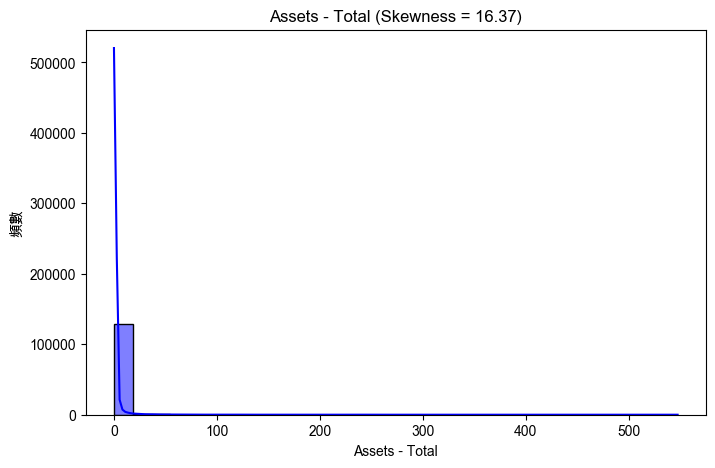

In [1182]:
column_name = 'Assets - Total'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

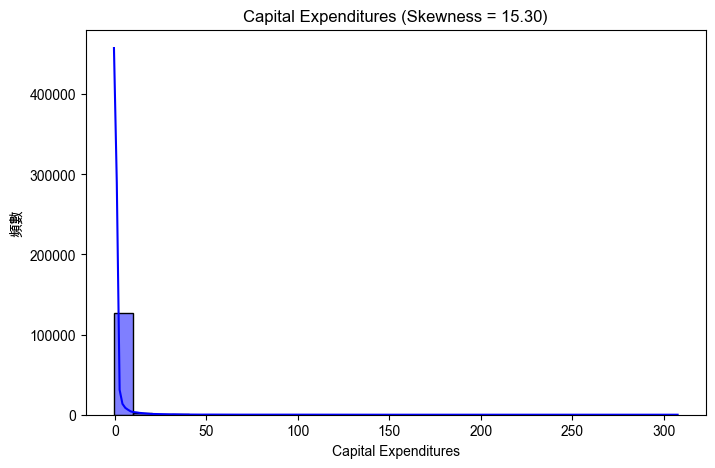

In [1183]:
column_name = 'Capital Expenditures'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

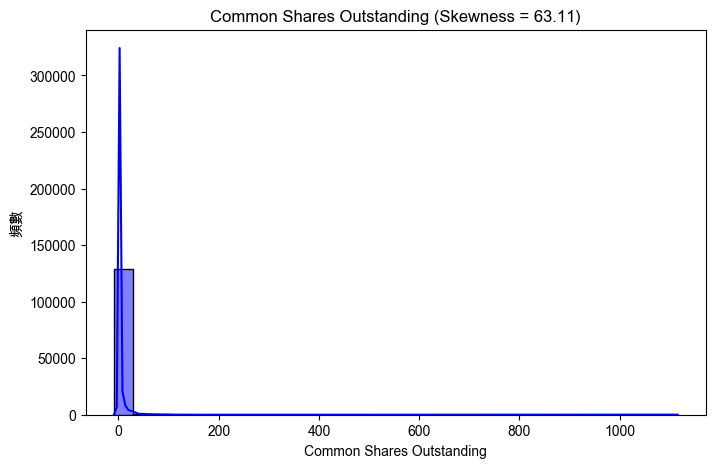

In [1184]:
column_name = 'Common Shares Outstanding'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

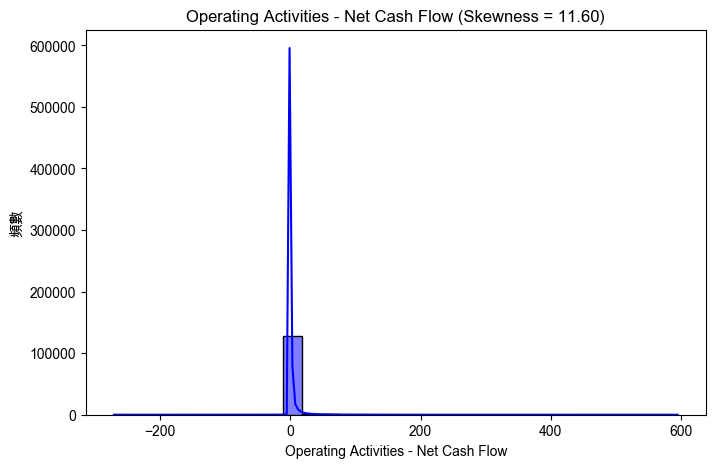

In [1185]:
column_name = 'Operating Activities - Net Cash Flow'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

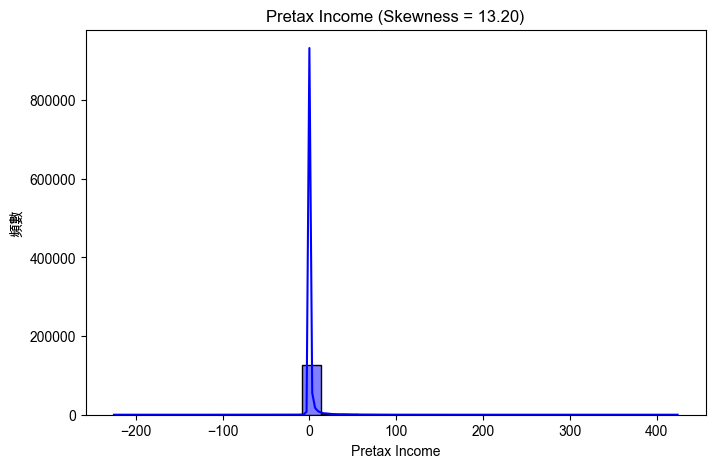

In [1186]:
column_name = 'Pretax Income'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

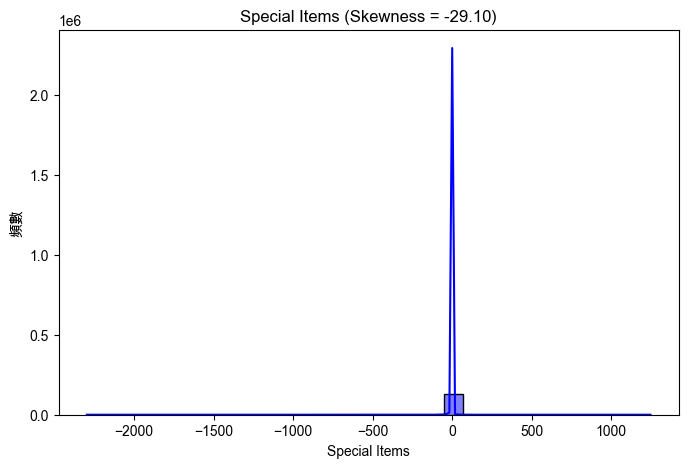

In [1187]:
column_name = 'Special Items'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

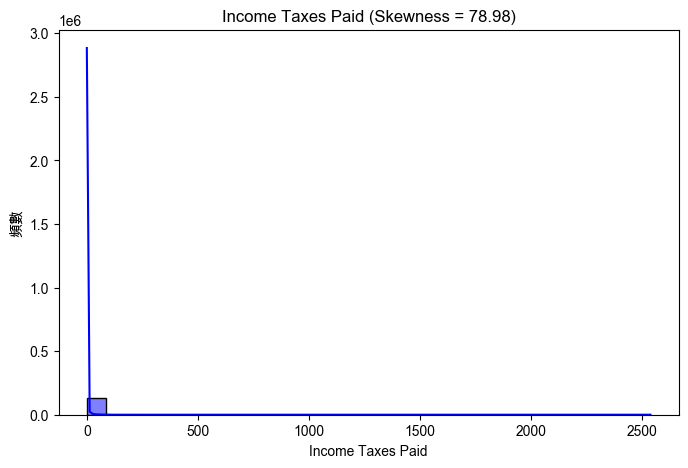

In [1188]:
column_name = 'Income Taxes Paid'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

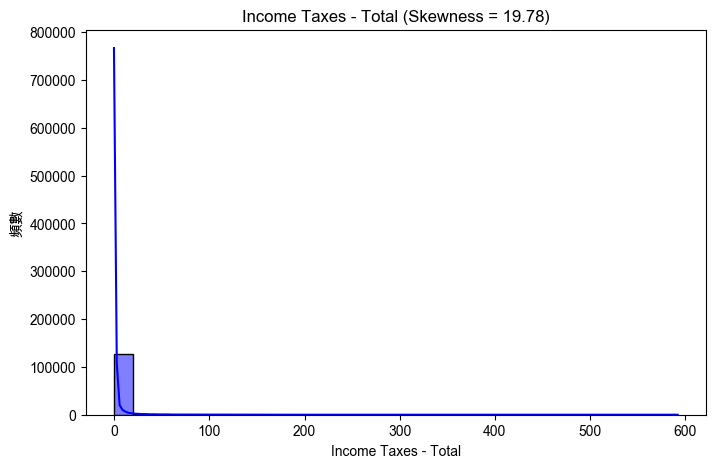

In [1189]:
column_name = 'Income Taxes - Total'

# 計算偏態係數
skewness = cleaned_data[column_name].skew()

# 繪製直方圖與密度圖
plt.figure(figsize=(8, 5))
sns.histplot(cleaned_data[column_name], kde=True, bins=30, color='blue')

# 添加標題與偏態係數
plt.title(f'{column_name} (Skewness = {skewness:.2f})')
plt.xlabel(column_name)
plt.ylabel('頻數')

# 顯示圖表
plt.show()

## 特徵工程

### OneHot encoding

將產業分類轉作onehot encoding

In [1190]:
cleaned_data = pd.get_dummies(
    cleaned_data, 
    columns=['Industry Format'],
    drop_first=True,
    dtype=int
)

In [1191]:
cleaned_data.head()

,Global Company Key,Data Date,Data Year - Fiscal,Level of Consolidation - Company Annual Descriptor,Population Source,Data Format,Ticker Symbol,CUSIP,Company Name,ISO Currency Code,...,Capital Expenditures,Common Shares Outstanding,Operating Activities - Net Cash Flow,Pretax Income,Special Items,Income Taxes Paid,Income Taxes - Total,Active/Inactive Status Marker,year,Industry Format_INDL
0,1004,1999/05/31,1998,C,D,STD,AIR,361105,AAR CORP,USD,...,-0.305167,-0.102951,-0.345041,-0.095685,0.025051,-0.274889,-0.116614,A,1998,1
1,1010,1998/12/31,1998,C,D,STD,4165A,00099V004,ACF INDUSTRIES HOLDING CORP,USD,...,0.097055,-0.437275,-0.116932,0.153910,0.025051,0.083895,0.254743,I,1998,1
2,1013,1998/10/31,1998,C,D,STD,ADCT,886309,ADC TELECOMMUNICATIONS INC,USD,...,0.053188,1.210549,-0.153794,0.749374,0.025051,0.990224,0.854514,I,1998,1
3,1019,1998/12/31,1998,C,D,STD,AFAP,1038108,AFA PROTECTIVE SYSTEMS INC,USD,...,-0.513654,-0.435357,-0.426557,-0.383965,0.025051,-0.332901,-0.381150,I,1998,1
4,1021,1998/06/30,1998,C,D,STD,IWKS,1058205,AFP IMAGING CORP,USD,...,-0.523862,-0.318125,-0.449259,-0.416755,-0.141336,-0.350536,-0.404498,I,1998,1


### 建立關鍵指標

#### BTD


- Book-Tax Difference (BTD) = 稅前收入 - 總所得稅
  - BTD 越高，代表企業可能有避稅行為。

- BTD > 0：公司帳面看起來賺得多，但課稅基礎比較少，通常是利用各種稅務優惠、折舊與攤銷方法、永久性差異等，可能有較強的「避稅傾向」。
- BTD = 0：帳面與稅務基本一致，差異不大，稅務規劃相對單純。
- BTD < 0：公司稅務申報所得比帳面盈餘還高，表示某些支出在稅務上不被承認或扣除，或有特殊規定增加計稅基礎。

In [1192]:
print(" - 建立 'BTD' (帳面稅差)")
cleaned_data['BTD'] = cleaned_data['Pretax Income'] - cleaned_data['Income Taxes - Total']

 - 建立 'BTD' (帳面稅差)


## 拆分數據集

In [1193]:
# 刪除不分析的資料
cleaned_data = cleaned_data.drop(columns=['Global Company Key', 'Data Date', 'Data Year - Fiscal',
       'Level of Consolidation - Company Annual Descriptor',
       'Population Source', 'Data Format', 'Ticker Symbol', 'CUSIP',
       'Company Name', 'ISO Currency Code', 'Active/Inactive Status Marker', 'year'])

In [1194]:
y = cleaned_data['BTD']
X = cleaned_data.drop(columns=['BTD'])

### Pearson Correlation

In [1195]:
X.corr().abs() > 0.8

,Assets - Total,Capital Expenditures,Common Shares Outstanding,Operating Activities - Net Cash Flow,Pretax Income,Special Items,Income Taxes Paid,Income Taxes - Total,Industry Format_INDL
Assets - Total,True,False,False,False,False,False,False,False,False
Capital Expenditures,False,True,False,False,False,False,False,False,False
Common Shares Outstanding,False,False,True,False,False,False,False,False,False
Operating Activities - Net Cash Flow,False,False,False,True,False,False,False,False,False
Pretax Income,False,False,False,False,True,False,False,True,False
Special Items,False,False,False,False,False,True,False,False,False
Income Taxes Paid,False,False,False,False,False,False,True,False,False
Income Taxes - Total,False,False,False,False,True,False,False,True,False
Industry Format_INDL,False,False,False,False,False,False,False,False,True


In [1196]:
# Income Taxes - Total 與 Pretax Income 相關性過高，刪除 Pretax Income
X = X.drop(columns=['Pretax Income'])

### 分割數據

In [1197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 建模

In [1198]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## 模型評估

In [1199]:
Y_train = model.predict(X_train)
mse = np.sum((Y_train - y_train) ** 2) / len(y_train)
print('train data - mse: ', mse)
r2 = r2_score(y_train, Y_train)
print(f"train data - R-squared: {r2:.4f}")

train data - mse:  11.292231868945313
train data - R-squared: 0.4306


In [1200]:
Y_test = model.predict(X_test)
mse = np.sum((Y_test - y_test) ** 2) / len(y_test)
print('test data - mse: ', mse)
r2 = r2_score(y_test, Y_test)
print(f"test data - R-squared: {r2:.4f}")

test data - mse:  9.176378706593038
test data - R-squared: 0.3823


## 結論

- R²=0.42 表示模型已解釋約 40% 的 BTD 變異，對財務數據而言並不算太差，但是模型的解釋力不夠，表示還有其他影響 BTD 的因素沒有被納入特徵（e.g. 總體經濟變數）。
- MSE 過高，表示模型與目標之間的適配度不佳，可能採用的模型形式不適合資料的結構（如非線性卻用了線性模型）